For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
np.random.seed(42)

In [4]:
n = 50000

In [5]:
def createRow(n, classes):
    # Selecting starting point as random from [0,1] we select random phase of the signal
    #By adding 10,15,7 we set frequency of the line
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n)) 
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [6]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)
    

[False False False False  True]


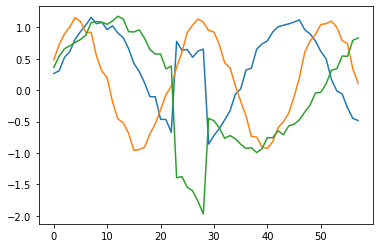

[False False False  True  True]


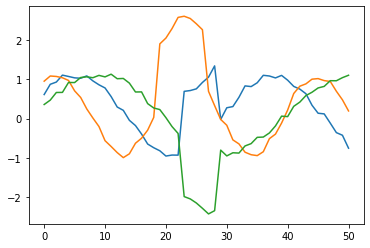

[False False False False False]


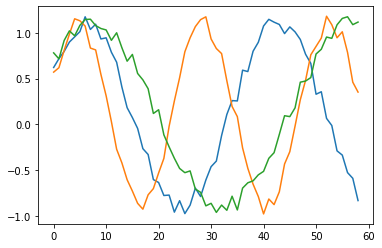

[ True False False False  True]


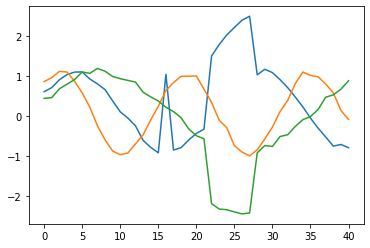

[False  True False False False]


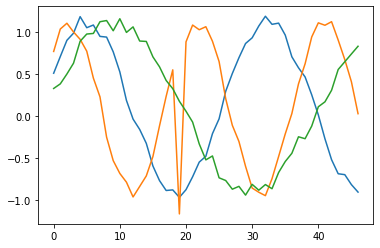

In [147]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

#### Small analysis

Assuming I know nothing about the signal lets check at first if these all have same lengths


In [148]:
type(xl), xl[0].shape, xl[1].shape #Clearly shapes don't match, we have 3 signals but their shapes differ

(list, (58, 3), (51, 3))

Lets see some statistics of these signal lengths. So signals are in range [40:60) and their length is uniformly distributed. <br>
So we can either pad all of them to match 59 once, or we can pad them dynamically. But since distribution is uniform and we have only 20 these values. For batch size like 512 we will end up padding them to 59 anyways. So we will pad them once

0,25,50,75, 100 quantiles: [40. 44. 49. 55. 59.]


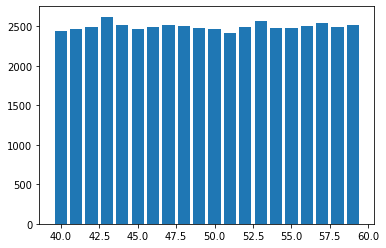

In [149]:
seq_lengths = np.array(list(map(lambda x: x.shape[0], xl)))
plt.bar(*np.unique(seq_lengths, return_counts=True))
print(f"0,25,50,75, 100 quantiles: {np.quantile(seq_lengths, [0,0.25,0.5,0.75,1])}")

#### Let's see if we could get some insights calculating means and std of the data

In [150]:
seq_stats = pd.DataFrame(map(lambda x: (*x[0].mean(axis=0), *x[0].std(axis=0),*x[1]), zip(xl,yl)), columns=[f"mean{i}" for i in range(3)] +[f"std{i}" for i in range(3)] + [f"def{i}" for i in range(5)])

In [151]:
seq_stats = seq_stats.iloc[np.random.choice(np.arange(n), size=n//5, replace=False),:] # filter the data so that plotly dpesn't die. Trends should be still visible
seq_stats_melted = pd.melt(seq_stats, id_vars=['mean0', 'mean1', 'mean2', 'std0', 'std1','std2'], value_vars=['def0','def1','def2','def3','def4' ])

In [152]:
px.strip(seq_stats_melted, x="mean0", color="value", facet_col="variable")


In [153]:
px.strip(seq_stats_melted, x="std1", color="value", facet_col="variable")


In [154]:
px.strip(seq_stats_melted, x="mean1", color="value", facet_col="variable")


In [155]:
px.strip(seq_stats_melted, x="mean2", color="value", facet_col="variable")


#### Try applying smoothing techniques to get original signal and find anomalies
If we believed that these perturbances are quite local we may try to smooth the signal and find outliers via subtraction. Next we can just select biggest residual from the signal

Boundary effect. THis may happens here and detriment LSTM work

In [156]:
def smooth(x,window_len=11,window='hanning'):
    """Function taken from https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html"""
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]

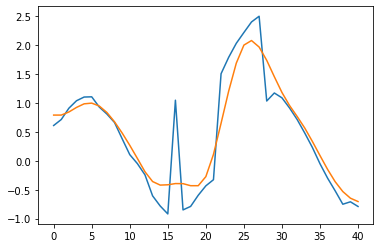

In [157]:
plt.plot(xl[3][:,0])
plt.plot(smooth(xl[3][:,0], window_len = 10))


So now one should just check if this works for all data by selecting biggest residual

#### Using derivative

We may check if these defects might have been created by some transients in the signal.

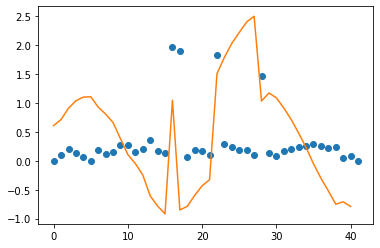

In [158]:
from scipy.signal import convolve

analyzed_signal = xl[3][:,0]
analyzed_signal = np.concatenate([[analyzed_signal[0]], analyzed_signal, [analyzed_signal[-1]]])
plt.plot(np.abs(convolve(analyzed_signal, [1,-1]))[1:-1], linestyle='None', marker="o") #first order derivative approximation
plt.plot(xl[3][:,0]) #first order derivative approximation

So calculate this derivatives for all plots and see how well this can do

## DL approach

In [7]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Firstly, we should split the data into train/test/val sets

In [11]:
x = []
for series in xl:
    if len(series) < 60:
        tmp = np.concatenate([series, np.zeros((60-len(series),3))]) #pad with zeros
    x.append(tmp)

In [12]:
x, yl = np.array(x), np.array(yl)


In [163]:
x.shape, yl.shape

((50000, 60, 3), (50000, 5))

In [18]:
train_split = 0.8
val_split = 0.9

train_x, train_y = x[:int(len(x)*train_split)], yl[:int(len(yl)*train_split)]
val_x = x[int(len(x)*train_split): int(len(x)*val_split)]
val_y = yl[int(len(yl)*train_split): int(len(yl)*val_split)]
test_x, test_y = x[int(len(x)*val_split):], yl[int(len(yl)*val_split):]


In [19]:
train_x[0].shape, train_y[0].shape

((60, 3), (5,))

Then, we can add a basic model - SimpleRNN

In [166]:
simple_model = Sequential()
simple_model.add(SimpleRNN(32, input_shape=(60,3)))
simple_model.add(Dense(5, activation='sigmoid'))
simple_model.compile(loss='binary_crossentropy', metrics=[
              tf.keras.metrics.BinaryAccuracy()])
simple_model.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 32)                1152      
                                                                 
 dense_18 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1,317
Trainable params: 1,317
Non-trainable params: 0
_________________________________________________________________


In [167]:
early = EarlyStopping(patience=7, restore_best_weights=True)
simple_model.fit(train_x, train_y, batch_size=64, epochs=50,
          validation_data=(val_x, val_y), callbacks=[early])


Epoch 1/50
625/625 [==============================] - 23s 36ms/step - loss: 0.5576 - binary_accuracy: 0.7505 - val_loss: 0.4753 - val_binary_accuracy: 0.7984
Epoch 2/50
625/625 [==============================] - 22s 35ms/step - loss: 0.4641 - binary_accuracy: 0.7959 - val_loss: 0.4516 - val_binary_accuracy: 0.8017
Epoch 3/50
625/625 [==============================] - 22s 35ms/step - loss: 0.4556 - binary_accuracy: 0.7975 - val_loss: 0.4475 - val_binary_accuracy: 0.8020
Epoch 4/50
625/625 [==============================] - 22s 36ms/step - loss: 0.4068 - binary_accuracy: 0.8213 - val_loss: 0.3410 - val_binary_accuracy: 0.8504
Epoch 5/50
625/625 [==============================] - 23s 37ms/step - loss: 0.3417 - binary_accuracy: 0.8453 - val_loss: 0.3163 - val_binary_accuracy: 0.8545
Epoch 6/50
625/625 [==============================] - 22s 36ms/step - loss: 0.3265 - binary_accuracy: 0.8507 - val_loss: 0.3033 - val_binary_accuracy: 0.8570
Epoch 7/50
625/625 [==============================] 

In [168]:
simple_model.evaluate(test_x, test_y)

157/157 [==============================] - 2s 14ms/step - loss: 0.1815 - binary_accuracy: 0.9271


[0.1815391629934311, 0.927079975605011]

In [169]:
model = Sequential()
model.add(LSTM(64, input_shape=(60, 3)))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=[
              tf.keras.metrics.BinaryAccuracy()])
model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 64)                17408     
                                                                 
 dense_19 (Dense)            (None, 5)                 325       
                                                                 
Total params: 17,733
Trainable params: 17,733
Non-trainable params: 0
_________________________________________________________________


In [170]:
early = EarlyStopping(patience=7, restore_best_weights=True)
model.fit(train_x, train_y, batch_size=64, epochs=50,
          validation_data=(val_x, val_y), callbacks=[early])

Epoch 1/50
625/625 [==============================] - 10s 13ms/step - loss: 0.4359 - binary_accuracy: 0.8077 - val_loss: 0.3399 - val_binary_accuracy: 0.8520
Epoch 2/50
625/625 [==============================] - 8s 12ms/step - loss: 0.3165 - binary_accuracy: 0.8597 - val_loss: 0.3474 - val_binary_accuracy: 0.8630
Epoch 3/50
625/625 [==============================] - 7s 12ms/step - loss: 0.2671 - binary_accuracy: 0.8859 - val_loss: 0.4187 - val_binary_accuracy: 0.8106
Epoch 4/50
625/625 [==============================] - 7s 12ms/step - loss: 0.2425 - binary_accuracy: 0.8967 - val_loss: 0.2038 - val_binary_accuracy: 0.9127
Epoch 5/50
625/625 [==============================] - 7s 12ms/step - loss: 0.2237 - binary_accuracy: 0.9046 - val_loss: 0.2348 - val_binary_accuracy: 0.9008
Epoch 6/50
625/625 [==============================] - 7s 11ms/step - loss: 0.2064 - binary_accuracy: 0.9132 - val_loss: 0.1727 - val_binary_accuracy: 0.9282
Epoch 7/50
625/625 [==============================] - 7s 

In [173]:
model.evaluate(val_x, val_y)


157/157 [==============================] - 1s 5ms/step - loss: 0.0090 - binary_accuracy: 0.9974


[0.009017524309456348, 0.9973999857902527]

In [171]:
model.evaluate(test_x, test_y)

157/157 [==============================] - 1s 6ms/step - loss: 0.0086 - binary_accuracy: 0.9976


[0.008603431284427643, 0.9975600242614746]

In [172]:
model.save('lstm')


INFO:tensorflow:Assets written to: lstm\assets


INFO:tensorflow:Assets written to: lstm\assets


We obtain very good results - 99.7% binary accuracy on the both test and validation data. It doesn't make any sense to train it further.

Now let's try to get the exact place of the anomaly. Firstly we use Gradient*Input method. It's an explainability measure of each input.

In [9]:
model = tf.keras.models.load_model('lstm')

In [26]:
x_tensor = tf.convert_to_tensor(x[0][None,:,:], dtype=tf.float32)
with tf.GradientTape() as t:
    t.watch(x_tensor)
    output = model(x_tensor)

result = output
gradients = t.gradient(output, x_tensor)


* xai gradient respect input keras
* instacje na ktorych robi pomylki - czy to charakterystyczne rzeczy

In [ ]:
simple_model = Sequential()
simple_model.add(SimpleRNN(32, input_shape=(60, 3)))
simple_model.add(Dense(5, activation='sigmoid'))
simple_model.compile(loss='binary_crossentropy', metrics=[
    tf.keras.metrics.BinaryAccuracy()])
simple_model.summary()
